In [1]:
import uuid

In [2]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

In [3]:
%%capture --no-stderr
%pip install -U langgraph langchain_anthropic langsmith langchain
# For the embedding-based classifier use in phase 2
%pip install -U sklearn langchain_openai
%pip install -U langchain-community

In [4]:
# (Optional) Enable tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "healthcare-transcripts"

if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LANGCHAIN_API_KEY: ")

In [5]:
import pandas as pd

data = pd.read_parquet("hf://datasets/urvog/llama2_transcripts_healthcare_callcenter/data/train-00000-of-00001-643ef6d7d804c522.parquet")

In [6]:
import logging
import operator
from typing import Annotated, List, Optional, TypedDict, Sequence
from langchain_core.messages import BaseMessage

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("health-chats-graph")

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    prompt: Annotated[Sequence[BaseMessage], operator.add]
    counter: int

In [7]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model='claude-3-haiku-20240307')

def remove_PII_information(state: State):
    user_input = state['messages'][-1]

    prompt = f"""Your task is to remove any PII information from the input. This PII information could be name, birthdate, policy number, medications, etc.
    Refer to the patient as "patient". {user_input}
    """

    correction_prompt = f"""Your previous task was to remove PII information from the user input. Check if you've removed all the instances of PII. 
    If you have missed something, remove it, add the word "Amended" at the beginning of the output, and return the corrected task output. 
    If you think that there's no PII information remaining, return the input as is.
    + {user_input}"""
    

    if state['counter'] is None:
        counter = 0
        response = llm.invoke(prompt)
        return {"messages": [response.content], "prompt": [prompt], "counter": [counter]}
    
    counter = int(state['counter'][0]) + 1
    response = llm.invoke(prompt)
    return {"messages": [response.content], "prompt": [correction_prompt], "counter": [counter]}
 
 
def get_symptoms_and_recommendations(state: State):
    agent_output = state['messages'][-1]

    prompt = """
    You have a task to return a dictionary with three keys - main_reason, symptoms and recommendations. If there's nothing for these categories, simply say "N/A"

    1. For main_reason, list the main reason for why the patient called.
    1. For symptoms, simply write what the symptoms patient reported.
    2. For recommendations, list two recommendations that the agent recommended. 

    Here's the format I'm expecting:
    {
        "main_reason: [],
        "symptoms": [],
        "recommendations": []
    }
    """ + agent_output
    
    response = llm.invoke(prompt)
    return {"messages": [response.content], "prompt": [prompt]}

def create_a_general_summary(state: State):
    agent_output = state['messages'][-1]
    
    prompt = """
    Given the input, create a general summary with less than 150 words.""" + agent_output

    response = llm.invoke(prompt)
    return {"messages": [response.content],  "prompt": [prompt]}

def should_continue(state: State):
    # Check if we should continue to the next step or loop over the current
    counter = state["counter"][0]
    if counter == 3:
        return "extract"
    return "continue"

def write_to_file(state: State):    
    previous_responses = pd.read_excel("responses.xlsx", sheet_name="Sheet1")

    all_prompts = {f"prompt-{idx}": prompt for idx, prompt in enumerate(state['prompt'])}
    all_responses = {f"response-{idx+1}": response for idx, response in enumerate(state['messages'][1:])}
    document = {"document": state['messages'][0]}
    batch_id = {"batch_id": uuid.uuid1().hex}    
    
    updated_responses = pd.concat([
        previous_responses,
        pd.DataFrame([{**document, **batch_id, **all_prompts, **all_responses}])
    ])
    updated_responses.to_excel("responses.xlsx", index=False)
    

In [8]:
from langgraph.graph import StateGraph, Graph, START, END

workflow = StateGraph(State)

workflow.add_node("pii_agent", remove_PII_information)
workflow.add_node("extractor", get_symptoms_and_recommendations)
workflow.add_node("summarizer", create_a_general_summary)
workflow.add_node("writer", write_to_file)

# workflow.add_edge("pii_agent", "extractor")
workflow.add_edge("extractor", "summarizer")
workflow.add_edge("summarizer", "writer")
workflow.add_edge(START, "pii_agent")
workflow.add_edge("writer", END)
# workflow.add_edge("pii_agent", END)
# workflow.add_edge("extractor", END)

workflow.add_conditional_edges(
    "pii_agent",
    should_continue,
    {
        "continue": "pii_agent",
        "extract": "extractor"
    }
)

graph = workflow.compile()


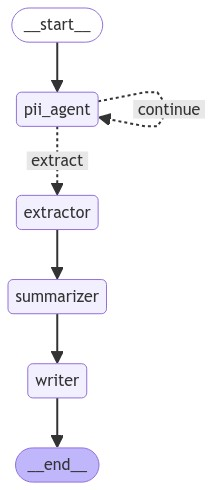

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass

In [29]:
input_text = "<s>[INST] Classify the following call transcript:\n\nAgent 4: Thank you for calling HealthHarbor. My name is Agent 4. How may I assist you today?\n\nCustomer: Hi, Agent 4. My name is Emily Johnson. I recently had a surgery at your hospital, and I have some concerns about my recovery. I'm feeling quite worried.\n\nAgent 4: I'm sorry to hear that, Emily. I'm here to help. Can you please share some details about your surgery and the concerns you have?\n\nCustomer: I had knee replacement surgery two weeks ago. While the pain has reduced, I'm still experiencing some discomfort and swelling. I'm worried if this is normal or if there's something wrong.\n\nAgent 4: I understand your concerns, Emily. It's normal to experience some discomfort and swelling during the recovery period. However, let me check your medical records to see if there's anything specific we need to address. Can you please provide me with your date of birth and the date of your surgery?\n\nCustomer: Certainly. My date of birth is January 15, 1975, and the surgery was conducted on August 5, 2022.\n\nAgent 4: Thank you for providing that information, Emily. I can see your records here. It seems you are still within the expected recovery timeline. However, I will schedule a follow-up appointment with your surgeon to discuss your concerns further. Would that be okay with you?\n\nCustomer: Yes, that would be great. I just want to ensure that everything is progressing as it should.\n\nAgent 4: Completely understandable, Emily. I will coordinate with your surgeon's office and schedule an appointment for you. You should receive a call from them within the next 24 hours to confirm the date and time. In the meantime, it's important to continue following the post-operative care instructions provided to you.\n\nCustomer: Thank you, Agent 4. I appreciate your help. I'll make sure to follow the instructions carefully.\n\nAgent 4: You're welcome, Emily. It's my pleasure to assist you. Is there anything else I can help you with today?\n\nCustomer: No, that's all for now. I feel much better knowing that I have a follow-up appointment scheduled. Thank you again for your assistance.\n\nAgent 4: You're welcome, Emily. I'm glad I could help. If you have any further questions or concerns, don't hesitate to reach out to us. Take care and have a speedy recovery.\n\nCustomer: Thank you, Agent 4. Goodbye.\n\nAgent 4: Goodbye, Emily. Have a great day. [/INST] Follow-up Calls and Care Management </s>"

output = graph.invoke({"messages": [input_text]})

## Process some examples

In [10]:
all_outputs = []
start = 5
end = 20

for transcript in data.iloc[start:end]['text'].values:
    output = graph.invoke({"messages": [transcript]})
    all_outputs.append(output)